In [34]:
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import os
import plotly.graph_objects as go

In [35]:
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "mito_result")

path = os.path.join(folder_path, "mito_data050.csv")
with open(path, 'r') as file:
    csvreader = csv.reader(file)
    data = []
    for row in csvreader:
        data.append(row)
    data = np.array(data)

In [36]:
print(data.shape)
radii = data[:, 0]
kt = data[:, 1]

(51, 2)


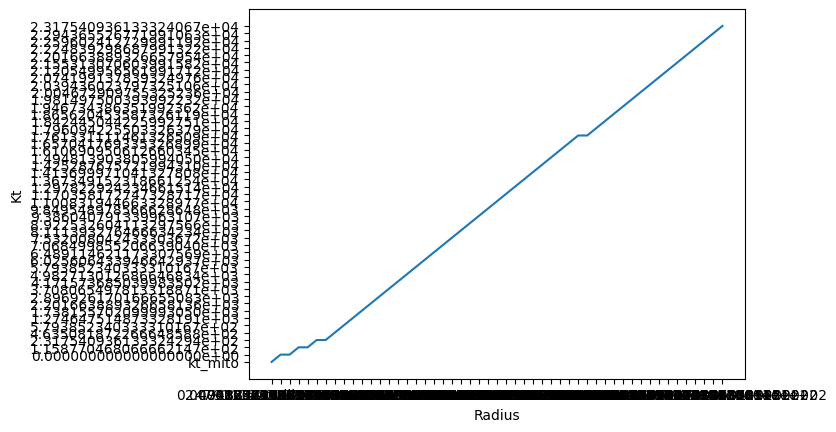

: 

In [37]:
plt.plot(radii, kt)
plt.xlabel("Radius")
plt.ylabel("Kt")
plt.show()